In [66]:
import sys
sys.path.append("../")

from config import Config
conf = Config()

from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from typing import Optional 
from langchain.chat_models import init_chat_model
from langgraph.store.base import BaseStore
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_core.tools import tool


from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import InMemorySaver

from typing import Literal
from pydantic import BaseModel, Field

######### ENV #########
from dotenv import load_dotenv

from datetime import datetime, timedelta

import pickle

load_dotenv()






True

In [ ]:

class MemoryResponse(BaseModel):
    """Respond to the user with this"""

    date_logged: datetime = Field(description = "Logging the date and time you set this memory")
    remember_window: datetime = Field(description="Remember for the current week, month, year or permanently")
    AImessage : str = Field(description="Final AI Message of the memory")
    context: str = Field(description="The context you want to save")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: MemoryResponse


@tool
def extract_goal_from_string(context: str):
    """This is function to extract the context to remember from the user query"""
    return context

@tool
def extract_date_logged(context: str):
    """This is function to extract the date to be logged"""
    return datetime.now()

@tool
def remember_window(remember_window_flag : Literal["days", "week", "month", "year", "permanently"],  n : int):
    """This is function to get the window till which the context needs to be remembered. 
    n can be 0 if we are referencing to the same day, week, month or month"""

    print(n)
    
    if remember_window_flag == "days":
        reminder_day = datetime.now() + timedelta(days=n)
        return reminder_day

    if remember_window_flag == "week":
        # Format the datetime object into the desired string format
        weekday = datetime.now().weekday()
        days_to_end = (6 - weekday)
        end_of_week = datetime.now() + timedelta(days=days_to_end)
        current_week =  end_of_week + timedelta(weeks=n)
        return current_week

    elif remember_window_flag == "month":
        # Format the datetime object into the desired string format
        current_month = datetime.now().strftime("%B %Y").replace(" 0", " ") 
        current_week =  end_of_week + timedelta(days=30*n)
        return current_month 
    

    elif remember_window_flag == "year":
        # Format the datetime object into the desired string format
        current_year = datetime.now().strftime("%Y").replace(" 0", " ") 
        current_year
        return current_year
    
    else:
        return remember_window_flag


tools = [extract_goal_from_string, remember_window, extract_date_logged, MemoryResponse]

remember_model =  conf.model.bind_tools(tools, tool_choice="any")

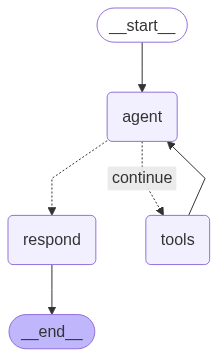

In [155]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = remember_model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    memory_tool_call = state["messages"][-1].tool_calls[0]
    response = MemoryResponse(**memory_tool_call["args"])
    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the MemoryResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    tool_message = {
        "type": "tool",
        "content": "Here is your structured response",
        "tool_call_id": memory_tool_call["id"],
    }
    # We return the final answer
    return {"final_response": response, "messages": [tool_message]}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "MemoryResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

graph = workflow.compile()
graph

In [156]:
answer = graph.invoke(input={"messages": [("human", "Remember to finish documents by next to next week")]})[
    "final_response"
]

answer

2


ValidationError: 1 validation error for MemoryResponse
remember_window
  Input should be a valid datetime or date, invalid character in year [type=datetime_from_date_parsing, input_value='July 6 2025', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/datetime_from_date_parsing

In [103]:
answer = graph.invoke(input={"messages": [("human", "Remember My Name is Siddharth")]})[
    "final_response"
]

answer

10


MemoryResponse(date_logged=datetime.datetime(2025, 6, 17, 0, 44, 41, 353334), remember_window='permanently', context='My Name is Siddharth')

In [ ]:
# Helper Function 
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "Remember to finish documents till the end of this week")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Remember to finish documents till tomorrow
================================== Ai Message ==================================
Tool Calls:
  extract_goal_from_string (call_N9wFqqeL8jQj5YUuYw8YO0PH)
 Call ID: call_N9wFqqeL8jQj5YUuYw8YO0PH
  Args:
    context: Remember to finish documents till tomorrow
  extract_date_logged (call_QRIe1RQMO81djlX0LcJYooF8)
 Call ID: call_QRIe1RQMO81djlX0LcJYooF8
  Args:
    context: Remember to finish documents till tomorrow
  remember_window (call_K4f2c8icJIr7otUpBR9Ge0rn)
 Call ID: call_K4f2c8icJIr7otUpBR9Ge0rn
  Args:
    remember_window_flag: week
================================= Tool Message =================================
Name: remember_window

June 22 2025
================================== Ai Message ==================================
Tool Calls:
  MemoryResponse (call_y0N0EmOwBQi9IPL05nHcfSum)
 Call ID: call_y0N0EmOwBQi9IPL05nHcfSum
  Args:
    context: Remember to 